In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv


### 📝 Cell 1: Libraries Import and Data Loading

This cell imports all necessary libraries (`pandas`, `numpy`, `sklearn`, `matplotlib`, `seaborn`) for data manipulation, modeling, and visualization.

It then loads the `loan_approval_dataset.csv` file using the verified file path on Kaggle and provides a quick initial inspection of the data structure.

In [9]:
# Cell 1: Libraries Import and Data Loading

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Optional: SMOTE import (kept for documentation, but will likely be skipped)
# from imblearn.over_sampling import SMOTE 

# Define the correct file path as confirmed by the user
FILE_PATH = "/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv" 

# Load the dataset
try:
    df = pd.read_csv(FILE_PATH)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at path: {FILE_PATH}")
    
# Quick data inspection
print("\n--- First 5 rows of data ---")
print(df.head())
print("\n--- Data types and Missing values info ---")
df.info()

Data loaded successfully.

--- First 5 rows of data ---
   loan_id   no_of_dependents      education  self_employed   income_annum  \
0        1                  2       Graduate             No        9600000   
1        2                  0   Not Graduate            Yes        4100000   
2        3                  3       Graduate             No        9100000   
3        4                  3       Graduate             No        8200000   
4        5                  5   Not Graduate            Yes        9800000   

    loan_amount   loan_term   cibil_score   residential_assets_value  \
0      29900000          12           778                    2400000   
1      12200000           8           417                    2700000   
2      29700000          20           506                    7100000   
3      30700000           8           467                   18200000   
4      24200000          20           382                   12400000   

    commercial_assets_value   luxury_asset

### 🧹 Cell 2: Data Cleaning and Preprocessing

This is the data preparation phase. We perform the following crucial steps:

1.  **Cleanup**: Drop unnecessary ID columns (`loan_id`) and clean column names.
2.  **Target Encoding**: Encode the categorical target variable (`loan_status`) into a numerical binary format (0 and 1) using `LabelEncoder`.
3.  **Missing Values**: Impute missing values using the **Mode** for categorical features and the **Median** for numerical features.

In [10]:
# Cell 2: Data Cleaning and Preprocessing

TARGET_COL = 'loan_status'

# 1. Initial cleanup
# Drop the ID column
if 'loan_id' in df.columns:
    df = df.drop('loan_id', axis=1)

# Clean column names (remove internal spaces and strip external spaces)
df.columns = df.columns.str.replace(' ', '', regex=True).str.strip()

# 2. Target Variable Encoding (Y=1, N=0)
if TARGET_COL in df.columns:
    le = LabelEncoder()
    df[TARGET_COL] = le.fit_transform(df[TARGET_COL])
    print(f"Target column '{TARGET_COL}' encoded successfully.")
    
# 3. Handle Missing Values
# Impute categorical columns with Mode
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Impute numerical columns with Median
numerical_cols = df.select_dtypes(include=np.number).columns.drop(TARGET_COL)
for col in numerical_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

print("\n--- Missing values count after preprocessing ---")
print(df.isnull().sum())

Target column 'loan_status' encoded successfully.

--- Missing values count after preprocessing ---
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64


### ✂️ Cell 3: Feature Encoding and Data Splitting

This cell prepares the data for model training:

1.  **One-Hot Encoding**: Convert the remaining categorical features into numerical format using `pd.get_dummies` (One-Hot Encoding).
2.  **Splitting**: Separate the features (X) from the target (y).
3.  **Train/Test Split**: Split the data into 70% for training and 30% for testing using the original **unbalanced data** with `stratify` to maintain the class ratio.

In [11]:
# Cell 3: Feature Encoding and Data Splitting

# 1. One-Hot Encoding for remaining categorical features
# drop_first=True avoids multicollinearity
df = pd.get_dummies(df, drop_first=True)
print("--- Data head after One-Hot Encoding ---")
print(df.head())

# 2. Separate Features (X) and Target (y)
X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]

# Display class balance (unbalanced data)
print("\n--- Original Class Balance ---")
print(y.value_counts())

# 3. Split data into training and testing sets (using original, unbalanced data)
# stratify=y ensures the class ratio is maintained in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y 
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

--- Data head after One-Hot Encoding ---
   no_of_dependents  income_annum  loan_amount  loan_term  cibil_score  \
0                 2       9600000     29900000         12          778   
1                 0       4100000     12200000          8          417   
2                 3       9100000     29700000         20          506   
3                 3       8200000     30700000          8          467   
4                 5       9800000     24200000         20          382   

   residential_assets_value  commercial_assets_value  luxury_assets_value  \
0                   2400000                 17600000             22700000   
1                   2700000                  2200000              8800000   
2                   7100000                  4500000             33300000   
3                  18200000                  3300000             23300000   
4                  12400000                  8200000             29400000   

   bank_asset_value  loan_status  education_ Not Gr

### 📊 Cell 4: Training and Evaluation: Logistic Regression (Baseline Model)

We train the **Logistic Regression** model as our baseline classification model.

The key output is the **Classification Report**, which explicitly provides the required evaluation metrics for imbalanced data: **Precision**, **Recall**, and **F1-score**. The Confusion Matrix visualizes the model's prediction errors.

  Classification Report: Logistic Regression Performance 

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.62      0.99      0.76       797
           1       0.48      0.02      0.04       484

    accuracy                           0.62      1281
   macro avg       0.55      0.50      0.40      1281
weighted avg       0.57      0.62      0.49      1281



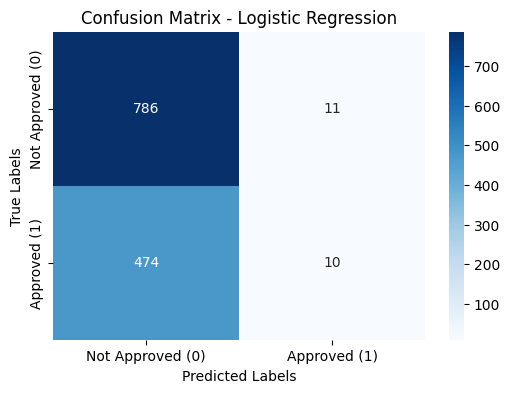

In [12]:
# Cell 4: Training and Evaluation of Logistic Regression

# Initialize and train the Logistic Regression model
log_model = LogisticRegression(random_state=42, max_iter=1000) 
log_model.fit(X_train, y_train)

# Predict on the test set
y_pred_log = log_model.predict(X_test)

print("=======================================================")
print("  Classification Report: Logistic Regression Performance ")
print("=======================================================")

# The classification report shows Precision, Recall, and F1-score
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_log))

# Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Approved (0)', 'Approved (1)'], 
            yticklabels=['Not Approved (0)', 'Approved (1)'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

### 🌳 Cell 5: Bonus - Decision Tree Comparison (Finding the Best Model)

This cell addresses the bonus requirement by training a **Decision Tree Classifier** and comparing its performance against Logistic Regression.

The final output is the second Classification Report and a direct comparison of the overall accuracy. We use the **F1-score and Recall** from these reports to make the final recommendation for the loan approval decision.

In [13]:
# Cell 5: Bonus - Decision Tree Comparison

# Initialize and train the Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Predict on the test set
y_pred_tree = tree_model.predict(X_test)

print("=======================================================")
print("  Classification Report: Decision Tree Performance ")
print("=======================================================")

# The classification report shows Precision, Recall, and F1-score
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_tree))

# Compare overall accuracy
log_accuracy = accuracy_score(y_test, y_pred_log)
tree_accuracy = accuracy_score(y_test, y_pred_tree)

print(f"\nOverall Accuracy (Logistic Regression): {log_accuracy:.4f}")
print(f"Overall Accuracy (Decision Tree): {tree_accuracy:.4f}")

# Final step: Analyze the F1-score and Recall values for both models to conclude which is better.

  Classification Report: Decision Tree Performance 

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       797
           1       0.97      0.96      0.97       484

    accuracy                           0.97      1281
   macro avg       0.97      0.97      0.97      1281
weighted avg       0.97      0.97      0.97      1281


Overall Accuracy (Logistic Regression): 0.6214
Overall Accuracy (Decision Tree): 0.9742
